In [0]:
!pip install --upgrade jax==0.1.57 jaxlib==0.1.37

from jax import jit, grad, vmap, random, jacrev, jacobian, jacfwd
from functools import partial
import jax
import jax.numpy as jp
import jax.scipy as jsp
from jax.nn import softmax, sigmoid
import matplotlib.pyplot as plt # visualization
import numpy as np
from jax.ops import index, index_add, index_update
import os, time
from jax.ops import index, index_add, index_update

rng=jax.random.PRNGKey(1234)

def matching_pennies():
  dims = [1, 1]
  payout_mat_1 = jp.array([[1,-1],[-1,1]])
  payout_mat_2 = -payout_mat_1
  def Ls(th):
    # th=jp.stack(th).reshape(-1)
    p_1, p_2 = sigmoid(th[0]), sigmoid(th[1])
    x, y = jp.array([p_1, 1-p_1]), jp.array([p_2, 1-p_2])
    # print(x.shape,y.shape,payout_mat_1.shape,payout_mat_2.shape)
    L_1 = jp.dot(jp.dot(x.T, payout_mat_1), y)
    L_2 = jp.dot(jp.dot(x.T, payout_mat_2), y)
    return jp.array([L_1.reshape(-1)[0], L_2.reshape(-1)[0]])
  return dims, Ls

def tandem():
  dims = [1, 1]
  def Ls(th):
    x, y = th[0], th[1]
    L_1 = (x+y)**2-2*x
    L_2 = (x+y)**2-2*y
    return jp.array([L_1.reshape(-1)[0], L_2.reshape(-1)[0]])
  return dims, Ls

def ipd(gamma=0.96):
  dims = [5, 5]
  payout_mat_1 = jp.array([[-1,-3],[0,-2]])
  payout_mat_2 = payout_mat_1.T
  def Ls(th):
    p_1_0 = sigmoid(th[0][0:1])
    p_2_0 = sigmoid(th[1][0:1])
    # print(p_1_0,p_2_0)
    p = jp.stack([p_1_0*p_2_0, p_1_0*(1-p_2_0), (1-p_1_0)*p_2_0, (1-p_1_0)*(1-p_2_0)], axis=1)
    # print(p.shape)
    p_1 = jp.reshape(sigmoid(th[0][1:5]), (4, 1))
    p_2 = jp.reshape(sigmoid(th[1][1:5]), (4, 1))
    P = jp.stack([p_1*p_2, p_1*(1-p_2), (1-p_1)*p_2, (1-p_1)*(1-p_2)], axis=1).reshape((4,4))
    # print(P.shape,P)
    M = -jp.dot(p, jsp.linalg.inv(jp.eye(4)-gamma*P))
    # print(M.shape, M)
    L_1 = jp.dot(M, jp.reshape(payout_mat_1, (4, 1)))
    L_2 = jp.dot(M, jp.reshape(payout_mat_2, (4, 1)))
    # print(L_1.shape, L_1, L_2.shape, L_2)
    return jp.array([L_1.reshape(-1)[0], L_2.reshape(-1)[0]])
  return dims, Ls

game_fn = {'imp':matching_pennies,
           'tandem':tandem,
           'ipd':ipd
           }

def init_th(dims, std, rng):
  th = []
  init=random.normal(rng, shape=(jp.sum(jp.array(dims)),))
  if std > 0:
    init*=std
  for i in range(len(dims)):
    th.append(init[:dims[i]])
    init=init[dims[i]:]
  return jp.array(th)

def update_th(algo, alpha=1.0, eta=1.0, beta=0.0, th=None, th0=None):
    losses = Ls(th)
    assert th0 is not None and th is not None

    grad_L = jacobian(Ls)(th) # n x n x d
    xi = jp.einsum('iij->ij',grad_L)
    if algo=='la': #Standard practice : eta=1.0, alpha=1.0
        full_hessian = jax.hessian(Ls)(th)
        off_diag_hessian = full_hessian
        for i in range(th.shape[0]):
            off_diag_hessian = index_update(off_diag_hessian, index[i,i,:,:,:], 0)
        second_term = jp.einsum('iim->im',jp.einsum('ijklm,jk->ilm', off_diag_hessian, xi))

        updates=eta*xi - alpha*second_term
        th = th - updates.reshape(th.shape)

    elif algo == 'lola0': #Standard practice : eta=1.0, alpha=1.0
        full_hessian = jax.hessian(Ls)(th)
        diag_hessian = jp.einsum('iijkl->ijkl', full_hessian)
        for i in range(th.shape[0]):
            diag_hessian = index_update(diag_hessian, index[i,:,i,:], 0)
        third_term = jp.einsum('iij->ij',jp.einsum('ijkl,mij->mkl',diag_hessian,grad_L))

        updates=eta*xi - alpha*third_term
        th = th - updates.reshape(th.shape)

    elif algo == 'l0mod':
        assert th.shape == th0.shape, 'th and th0 needs to be of same shape'
        assert th.shape[0] == 2, "This is only for two-players, more than two passed here."
        difference = th-th0
        full_hessian = jax.hessian(Ls)(th)
        diag_hessian = jp.einsum('iijkl->ijkl', full_hessian)
        for i in range(th.shape[0]):
            diag_hessian = index_update(diag_hessian, index[i,:,i,:], 0)
        diff_term = jp.zeros((th.shape[0], th.shape[0], th.shape[1]))
        diff_term = index_update(diff_term, index[0, 1] , difference[1])
        diff_term = index_update(diff_term, index[1, 0] , difference[0])
        third_term = jp.einsum('iij->ij',jp.einsum('ijkl,mij->mkl',diag_hessian,diff_term))

        updates=eta*xi - alpha*third_term
        th = th - updates.reshape(th.shape)

    elif algo == 'lola': #Standard practice : eta=1.0, alpha=1.0
        full_hessian = jax.hessian(Ls)(th)
        off_diag_hessian = full_hessian
        for i in range(th.shape[0]):
            off_diag_hessian = index_update(off_diag_hessian, index[i,i,:,:,:], 0)
        second_term = jp.einsum('iim->im',jp.einsum('ijklm,jk->ilm', off_diag_hessian, xi))
        diag_hessian = jp.einsum('iijkl->ijkl', full_hessian)
        for i in range(th.shape[0]):
            diag_hessian = index_update(diag_hessian, index[i,:,i,:], 0)
        third_term = jp.einsum('iij->ij',jp.einsum('ijkl,mij->mkl',diag_hessian,grad_L))

        updates=eta*xi - alpha*second_term - alpha*third_term
        th = th - updates.reshape(th.shape)

    elif algo == 'ld':
        assert th.shape == th0.shape, 'th and th0 needs to be of same shape'
        assert th.shape[0] == 2, "This is only for two-players, more than two passed here."
        difference = th-th0
        full_hessian = jax.hessian(Ls)(th)
        diag_hessian = jp.einsum('iijkl->ijkl', full_hessian)
        for i in range(th.shape[0]):
            diag_hessian = index_update(diag_hessian, index[i,:,i,:], 0)
        diff_term = jp.zeros((th.shape[0], th.shape[0], th.shape[1]))
        diff_term = index_update(diff_term, index[0, 1] , difference[1])
        diff_term = index_update(diff_term, index[1, 0] , difference[0])
        third_term = jp.einsum('iij->ij',jp.einsum('ijkl,mij->mkl',diag_hessian,diff_term))

        updates = eta*xi - beta*(th-th0) - alpha*third_term
        th0 = th
        th = th - updates.reshape(th.shape)

    elif algo == 'nl': # Naive Learning
        updates = eta * xi
        th = th - updates.reshape(th.shape)

    return th, th0, losses



     |████████████████████████████████| 256kB 3.3MB/s 
     |████████████████████████████████| 25.4MB 119kB/s 
  Created wheel for jax: filename=jax-0.1.57-cp36-none-any.whl size=297710 sha256=5af7914361e394108f268e29c6188f62bb1ae7f275770db1b8975329e9e124d3
  Stored in directory: /root/.cache/pip/wheels/8a/b4/75/859bcdaf181569124306615bd9b68c747725c60bfa68826378
Successfully built jax
  Found existing installation: jax 0.1.52
    Uninstalling jax-0.1.52:
      Successfully uninstalled jax-0.1.52
  Found existing installation: jaxlib 0.1.36
    Uninstalling jaxlib-0.1.36:
      Successfully uninstalled jaxlib-0.1.36


/usr/local/lib/python3.6/dist-packages/jax/lib/xla_bridge.py:119: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


9 11 198 198 198 990
...


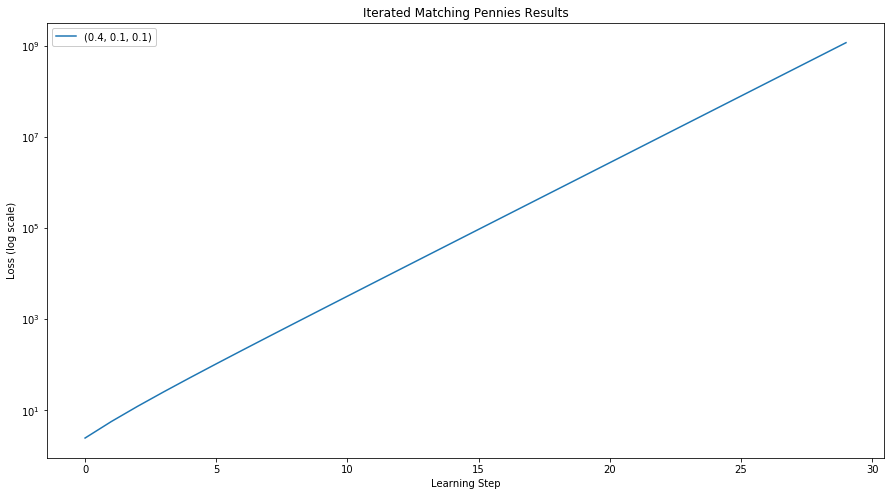

...


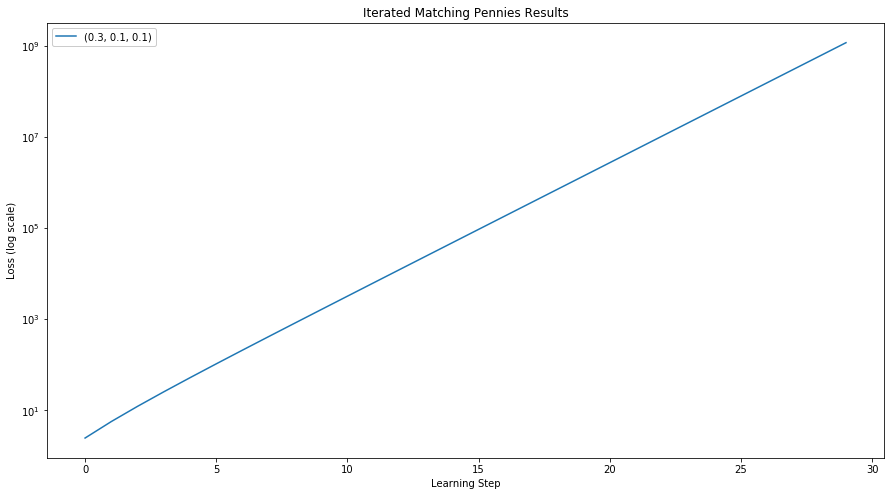

...


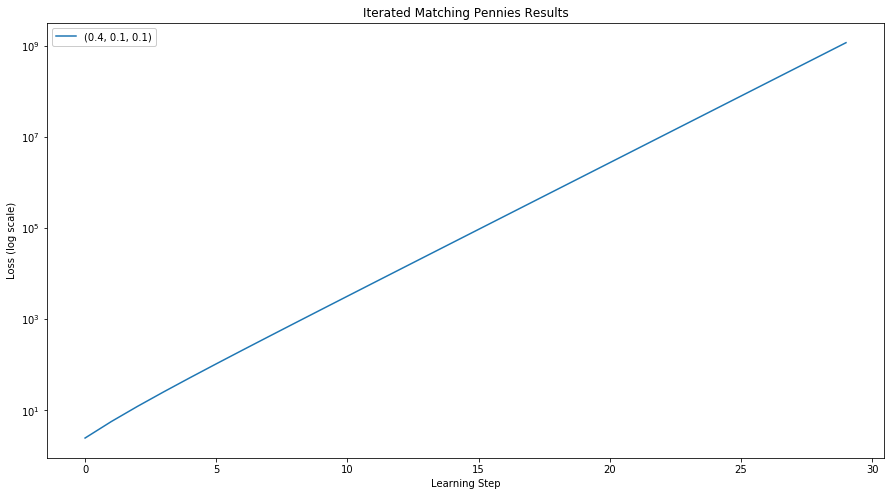

...


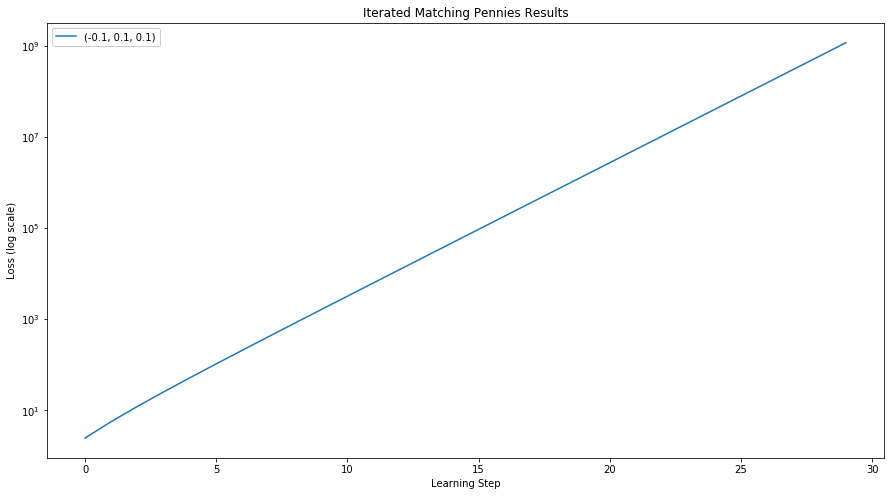

...


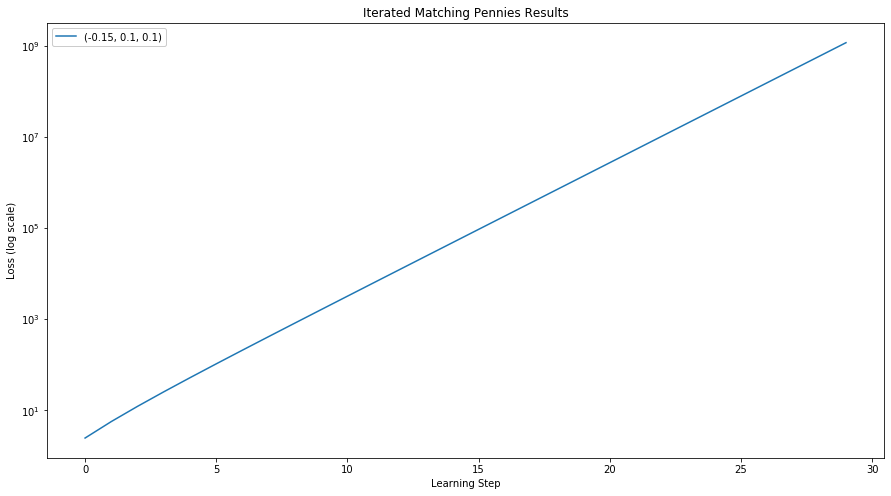

...


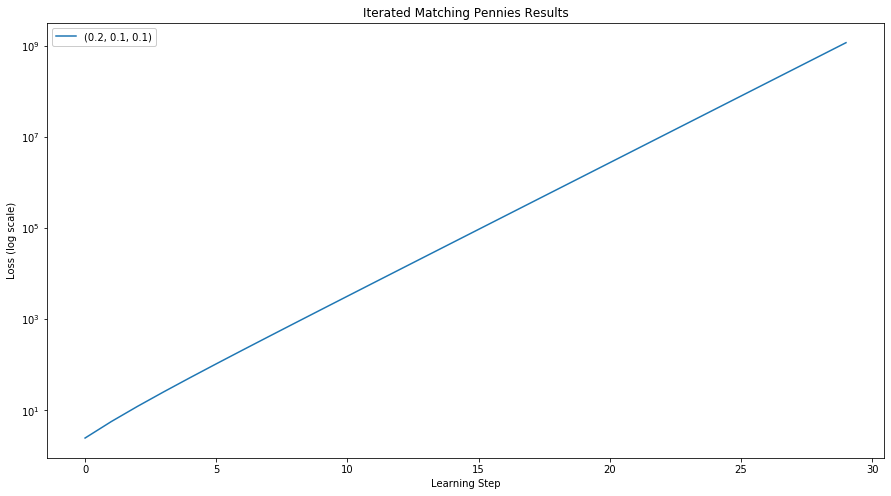

...


KeyboardInterrupt: ignored

In [0]:
''' ####### Tandem ####### '''
from itertools import product
import random as rnd
from copy import deepcopy

game = 'tandem'
std = 1
num_runs = 50
num_epochs = 30

dims, Ls = game_fn[game]()
theta = vmap(partial(init_th, dims, std))(jax.random.split(rng, num_runs))
theta0 = jp.zeros_like(theta)

def alpha_fn(eta, beta):
    term1=eta*beta
    term2=1-beta
    return (2*term1+term2**2)/term1/term2

def alpha_fn1(beta, eta):
    term1=beta*eta
    term2=1-beta
    return 2*term1/term2+term2

def alpha_fn2(beta, eta):
    term1=eta
    term2=1-beta
    return 2*term1/term2+term2

beta_pos = [0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5]
beta_neg = [-x for x in beta_pos]
eta = [1e-5,5e-5,1e-4,5e-4,1e-3,5e-3,1e-2,5e-2,0.1,0.5,1.0]
perm1 = list(product(beta_pos, eta))
perm2 = list(product(beta_neg, eta))
perm = perm1+perm2
a1list = [(b,e,alpha_fn1(b,e)) for b,e in perm]
a2list = [(b,e,alpha_fn2(b,e)) for b,e in perm]
a3list = [(b,e,0.1*alpha_fn(e,b)) for b,e in perm]
a4list = [(b,e,0.25*alpha_fn(e,b)) for b,e in perm]
a5list = [(b,e,0.5*alpha_fn(e,b)) for b,e in perm]
params = a1list+a2list+a3list+a4list+a5list
rnd.shuffle(params)
print(len(beta_pos),len(eta),len(perm),len(a1list),len(a2list),len(params))

# update_fn = jit(update_th)


def plot_imp(algolist, mode='0', scale='log'):
    t1 = time.time()
    plt.figure(figsize=(15, 8))
    for algo in [s.lower() for s in algolist]:
        print(algo)
        losses_out = np.zeros((num_runs, num_epochs))
        th, th0 = theta, theta0
        for k in range(num_epochs):
            th, th0, losses = update_fn[algo](th, th0)
            losses_out[:,k] = losses[:,0]
        new_loss = [np.linalg.norm(loss) for loss in jp.mean(losses_out, axis=0)]
        plt.plot(new_loss)
    if scale == 'log':
        plt.yscale('log')
    plt.title('Iterated Matching Pennies Results')
    plt.xlabel('Learning Step')
    plt.ylabel('Loss (log scale)')
    plt.legend(algolist, loc='best', frameon=True, framealpha=1, ncol=3)
    # plt.show()
    print('Jax time:', time.time() - t1)

def myplot(losses, param):
    plt.figure(figsize=(15, 8))
    plt.plot(losses)
    plt.yscale('log')
    plt.title('Iterated Matching Pennies Results')
    plt.xlabel('Learning Step')
    plt.ylabel('Loss (log scale)')
    plt.legend([param], loc='best', frameon=True, framealpha=1, ncol=3)
    plt.show()


def tune_imp(params):
    lossmap = {}
    for beta, eta, alpha in params:
        print('...')
        losses_out = np.zeros((num_runs, num_epochs))
        th, th0 = theta, theta0
        func = jit(vmap(partial(update_th, 'ld', alpha, eta, beta), in_axes=(0, 0), out_axes=(0, 0, 0)))
        for k in range(num_epochs):
            th, th0, losses = func(th, th0)
            losses_out[:,k] = losses[:,0]
        lossmap[(beta, eta, alpha)] = losses_out
        loss_value = jp.mean(jp.array([np.linalg.norm(l) for l in jp.mean(losses_out, axis=0)][-50:]))
        if loss_value < 1e-8:
            print(beta, eta, alpha)
        new_loss = jp.mean(losses_out, axis=0)
        myplot(new_loss, (beta, eta, alpha))
# tune_imp([(0.1,1.0,0.25*alpha_fn(1.0,0.1)), (0.1,1.0,0.2*alpha_fn(1.0,0.1))])
tune_imp(params)

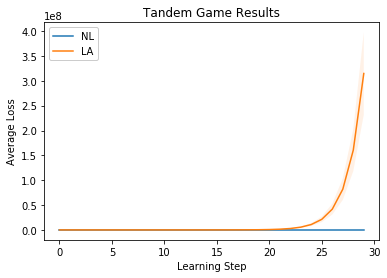

In [0]:
#@title Tandem Jax Compare LOLA0 with L0MOD with similar coeff
'''Tandem Game - SOS vs LOLA'''
num_runs = 100
num_epochs = 30

dims, Ls = tandem()
std = 0.1
theta = vmap(partial(init_th, dims, std))(jax.random.split(rng, num_runs))
theta0 = jp.zeros_like(theta)

alpha = 0.1

beta = 0
eta = 0.1
update_fn={'nl':jit(vmap(partial(update_th, 'nl', alpha, eta, beta), in_axes=(0, 0), out_axes=(0, 0, 0))),
           'la':jit(vmap(partial(update_th, 'la', alpha, eta, beta), in_axes=(0, 0), out_axes=(0, 0, 0))),
           'lola':jit(vmap(partial(update_th, 'lola', alpha, eta, beta), in_axes=(0, 0), out_axes=(0, 0, 0))),
           'lola0':jit(vmap(partial(update_th, 'lola0', alpha, eta, beta), in_axes=(0, 0), out_axes=(0, 0, 0)))}

for algo in ['nl', 'la']:
    losses_out = np.zeros((num_runs, num_epochs))
    th, th0 = theta, theta0
    for k in range(num_epochs):
      th, _, losses = update_fn[algo](th, th0)
      losses_out[:, k] = losses[:,0]

    mean = np.mean(losses_out, axis=0)
    dev = np.std(losses_out, axis=0)
    plt.plot(np.arange(num_epochs), mean)
    plt.fill_between(np.arange(num_epochs), mean-dev, mean+dev, alpha=0.1)

plt.title('Tandem Game Results')
plt.xlabel('Learning Step')
plt.ylabel('Average Loss')
plt.legend(['NL', 'LA'], loc='upper left', frameon=True, framealpha=1)
plt.show()